In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings("ignore")

In [24]:
# DATA PATH
TRAIN_DATA_PATH = os.path.join("..","datasets","processed","train.csv")
TEST_DATA_PATH = os.path.join("..","datasets","processed","test.csv")
TRAIN_DATA_PATH

'../datasets/processed/train.csv'

In [25]:
train_data = pd.read_csv(TRAIN_DATA_PATH, parse_dates=['Month'], index_col='Month', squeeze=True)
test_data = pd.read_csv(TEST_DATA_PATH, parse_dates=['Month'], index_col='Month', squeeze=True)
train_data

,AirPassengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-02-01,391
1960-03-01,419
1960-04-01,461


In [26]:
# ARIMA Model
model = ARIMA(train_data, order=(1,1,2))
model_fitted = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          AirPassengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -688.749
Date:                Thu, 18 Aug 2022   AIC                           1385.498
Time:                        11:38:49   BIC                           1397.349
Sample:                    01-01-1949   HQIC                          1390.313
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5724      0.097      5.928      0.000       0.383       0.762
ma.L1         -0.3126      0.098     -3.198      0.001      -0.504      -0.121
ma.L2         -0.5078      0.069     -7.412      0.0

### 2.1.5 ARIMA Model Diagnostic

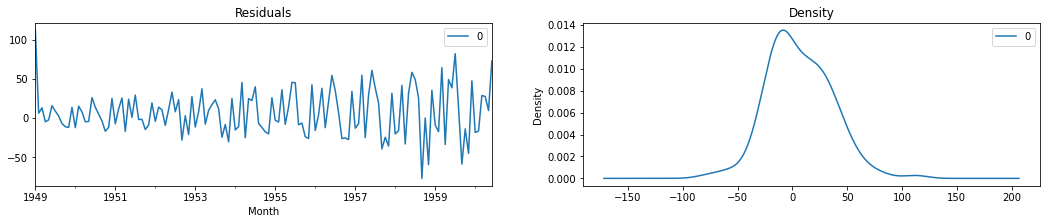

In [27]:
# Plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2, figsize=(18,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

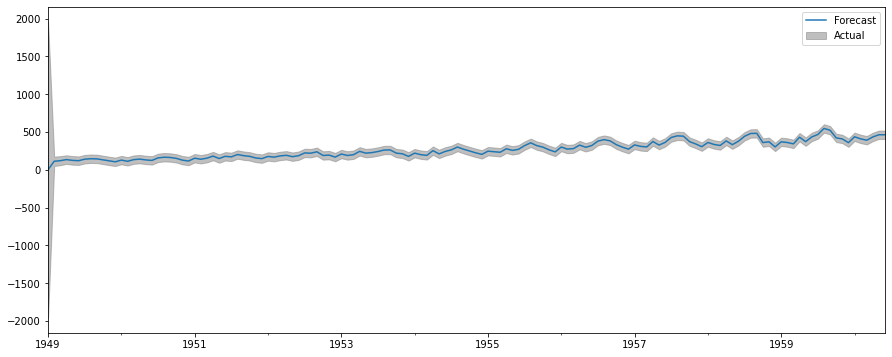

In [28]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,6))
plot_predict(model_fitted, dynamic=False, ax=ax)
plt.legend(["Forecast","Actual"])
plt.show()

In [33]:
# Build ARIMA Model  
model = ARIMA(train_data, order=(1, 1, 2))  
fitted = model.fit()  

# ARIMA Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(18,6), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: 'float' object is not subscriptable

### 2.1.6 ARIMA Performance Metrics

In [ ]:
# ARIMA Model Performance Metrics
arima_performance = forecast_accuracy(test.values, fc)
print("ARIMA Performance:")
print("="*24)
for k, v in arima_performance.items():
    print(k +" : "+ str(v))